### Exploring the data

In [395]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [339]:
!python --version

Python 3.12.7


In [340]:
pd.__version__

'2.2.3'

In [341]:
sklearn.__version__

'1.6.1'

In [342]:
!pip install pyarrow

In [343]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")

In [344]:
# df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")

# # calculating the trip duration
# df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

# # convert from seconds to minutes
# df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# # take a subset
# df = df[(df.duration >=1) & (df.duration <= 60)]

# # selecting the variables
# categorical = ['PULocationID', 'DOLocationID']
# numerical = ['trip_distance']

# # convert to a string
# df[categorical] = df[categorical].astype(str)

In [345]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,1.0,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,1.0,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,1.0,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,1.0,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,1.0,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00


In [346]:
# calculating the trip duration
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df['duration']

0       0 days 00:11:30
1       0 days 00:20:52
2       0 days 00:19:02
3       0 days 00:11:52
4       0 days 00:10:59
              ...      
56546   0 days 00:09:00
56547   0 days 00:05:00
56548   0 days 00:04:00
56549   0 days 00:06:00
56550   0 days 00:31:00
Name: duration, Length: 56551, dtype: timedelta64[us]

In [347]:
# convert from seconds to minutes
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [348]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333


In [349]:
# filtering data by trip_type = dispatch
df[df.trip_type == 2]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
36,2,2024-01-01 00:15:43,2024-01-01 00:15:51,N,5.0,61,61,2.0,0.00,22.00,...,0.0,0.00,0.00,NaN,1.0,23.00,2.0,2.0,0.00,0.133333
45,2,2024-01-01 00:34:56,2024-01-01 00:34:57,N,5.0,66,264,2.0,0.00,50.00,...,0.0,10.20,0.00,NaN,1.0,61.20,1.0,2.0,0.00,0.016667
56,2,2024-01-01 00:52:23,2024-01-01 01:07:39,N,5.0,74,127,1.0,5.76,25.55,...,0.0,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,15.266667
58,2,2024-01-01 00:55:10,2024-01-01 01:22:19,N,5.0,189,91,2.0,5.04,30.99,...,0.0,6.40,0.00,NaN,1.0,38.39,1.0,2.0,0.00,27.150000
59,2,2024-01-01 00:56:37,2024-01-01 00:56:42,N,5.0,173,173,1.0,0.00,15.00,...,0.0,0.00,0.00,NaN,1.0,16.00,1.0,2.0,0.00,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53099,2,2024-01-31 22:10:36,2024-01-31 22:16:46,N,5.0,42,74,1.0,1.03,8.00,...,0.0,0.00,0.00,NaN,1.0,9.00,2.0,2.0,0.00,6.166667
53110,2,2024-01-31 23:19:51,2024-01-31 23:52:04,N,5.0,25,162,2.0,8.32,40.00,...,0.0,2.00,6.94,NaN,1.0,52.69,1.0,2.0,2.75,32.216667
53123,2,2024-01-31 23:57:29,2024-02-01 00:24:07,N,5.0,181,100,2.0,6.16,60.00,...,0.0,12.75,0.00,NaN,1.0,76.50,1.0,2.0,2.75,26.633333
53133,2,2024-01-31 23:19:14,2024-01-31 23:19:27,N,5.0,181,181,2.0,0.00,74.00,...,0.0,10.00,0.00,NaN,1.0,85.00,1.0,2.0,0.00,0.216667


/tmp/ipykernel_3757/813963452.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

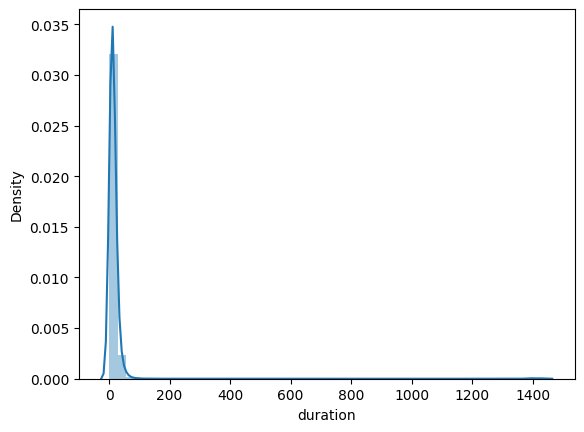

In [350]:
# distribution of the duration
sns.distplot(df.duration)

In [351]:
# show basic statistics
df.duration.describe()

count    56551.000000
mean        18.171379
std         75.464751
min          0.000000
25%          7.250000
50%         11.400000
75%         17.316667
max       1438.983333
Name: duration, dtype: float64

In [352]:
# look at the percentiles 95%, 98% abd 99%
df.duration.describe(percentiles = [0.95, 0.98, 0.99])

count    56551.000000
mean        18.171379
std         75.464751
min          0.000000
50%         11.400000
95%         33.683333
98%         46.816667
99%         59.825000
max       1438.983333
Name: duration, dtype: float64

In [353]:
# filtering the trips in the interval [1 min, 60 min]
((df.duration >= 1) & (df.duration <= 60)).mean()

0.9614860921999611

In [354]:
# take a subset
df = df[(df.duration >=1) & (df.duration <= 60)]

In [355]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.80,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.30,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.80,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.20,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.60,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56546,2,2024-01-31 20:46:00,2024-01-31 20:55:00,None,NaN,33,25,NaN,0.00,11.58,...,0.0,3.14,0.0,NaN,1.0,15.72,NaN,NaN,NaN,9.000000
56547,2,2024-01-31 21:06:00,2024-01-31 21:11:00,None,NaN,72,72,NaN,0.49,11.58,...,0.0,0.00,0.0,NaN,1.0,12.58,NaN,NaN,NaN,5.000000
56548,2,2024-01-31 21:36:00,2024-01-31 21:40:00,None,NaN,72,72,NaN,0.52,11.58,...,0.0,2.52,0.0,NaN,1.0,15.10,NaN,NaN,NaN,4.000000
56549,2,2024-01-31 22:45:00,2024-01-31 22:51:00,None,NaN,41,42,NaN,1.17,14.22,...,0.0,0.00,0.0,NaN,1.0,15.22,NaN,NaN,NaN,6.000000


In [356]:
# selecting the variables
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [357]:
df[categorical].dtypes

PULocationID    int32
DOLocationID    int32
dtype: object

In [358]:
# convert to a string
df[categorical] = df[categorical].astype(str)

In [359]:
df.dtypes

VendorID                          int32
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [360]:
# # convert the features from dataframes to dictionaries (rows)
# train_dicts = df[categorical + numerical].to_dict(orient='records')

# # inicialize an instance
# dv = DictVectorizer()

# # build train data
# X_train = dv.fit_transform(train_dicts)

# # target variable
# target = 'duration'
# y_train = df[target].values

# # initialize model
# lr = LinearRegression()

# # fit the model
# lr.fit(X_train, y_train)

# # calculate the predictions
# y_pred = lr.predict(X_train)

# # evaluate the model - trainning dataset
# # mean_squared_error(y_train, y_pred, squared=False)
# RMSE = root_mean_squared_error(y_train, y_pred)

In [361]:
# convert the features from dataframes to dictionaries (rows)
# df[categorical + numerical].iloc[:10].to_dict(orient='records') # just to show the result

train_dicts = df[categorical + numerical].to_dict(orient='records')

In [362]:
# inicialize an instance
dv = DictVectorizer()

# build train data
X_train = dv.fit_transform(train_dicts)

In [363]:
X_train.shape

(54373, 449)

In [364]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 163119 stored elements and shape (54373, 449)>

In [365]:
# dv.feature_names_

In [366]:
# target variable
target = 'duration'
y_train = df[target].values

In [367]:
y_train

array([11.5       , 20.86666667, 19.03333333, ...,  4.        ,
        6.        , 31.        ])

In [368]:
# initialize model
lr = LinearRegression()

# fit the model
lr.fit(X_train, y_train)

LinearRegression()

In [369]:
# calculate the predictions
y_pred = lr.predict(X_train)

In [370]:
y_pred

array([10.83670091, 26.19138438, 14.74817784, ..., 27.39585639,
        8.36547539, 22.7543219 ])

/tmp/ipykernel_3757/2101131158.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_3757/2101131158.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


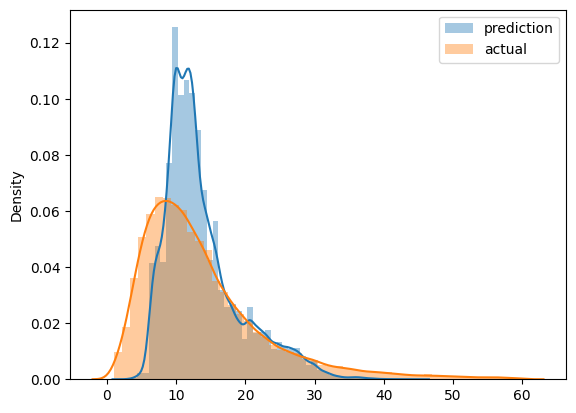

In [371]:
# plot the grap prediction x actual value
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [372]:
# evaluate the model - trainning dataset
# mean_squared_error(y_train, y_pred, squared=False)
RMSE = root_mean_squared_error(y_train, y_pred)

In [373]:
# our model is wrong by around 7 minutes - training data
# RMSE of categorical + numerical = 7.1228220948023795
# RMSE of just numerical = 9.019532837014284
RMSE

7.1228220948023795

### Organizing in functions

In [374]:
def read_dataframe(filename):

    # "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet"
    df = pd.read_parquet(filename)

    # calculating the trip duration
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    
    # convert from seconds to minutes
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # take a subset
    df = df[(df.duration >=1) & (df.duration <= 60)]
    
    # selecting the variables
    categorical = ['PULocationID', 'DOLocationID']
    
    # convert to a string
    df[categorical] = df[categorical].astype(str)

    return df

In [375]:
# df_train = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
# df_val = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")

df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")

In [376]:
df_train.shape, df_val.shape

((54373, 21), (51497, 21))

In [377]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333


In [387]:
# feature engineering
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [388]:
df_val.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2024-02-01 00:15:53,2024-02-01 00:24:20,N,1.0,75,161,1.0,2.77,13.5,...,3.75,0.0,NaN,1.0,22.50,1.0,1.0,2.75,8.450000,75_161
1,2,2024-01-31 22:59:22,2024-01-31 23:27:14,N,1.0,43,242,1.0,7.76,36.6,...,0.00,0.0,NaN,1.0,39.10,2.0,1.0,0.00,27.866667,43_242
2,2,2024-02-01 00:30:29,2024-02-01 00:35:32,N,1.0,75,238,1.0,1.03,7.9,...,2.60,0.0,NaN,1.0,13.00,1.0,1.0,0.00,5.050000,75_238
3,2,2024-01-31 23:56:42,2024-02-01 00:06:53,N,1.0,80,17,2.0,1.36,11.4,...,4.17,0.0,NaN,1.0,18.07,1.0,1.0,0.00,10.183333,80_17
5,2,2024-02-01 00:06:23,2024-02-01 00:10:10,N,1.0,97,25,1.0,0.34,5.1,...,0.00,0.0,NaN,1.0,7.60,2.0,1.0,0.00,3.783333,97_25


In [389]:
# selecting the variables
# categorical = ['PULocationID', 'DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']

# inicialize an instance
dv = DictVectorizer()

# convert the features from dataframes to dictionaries (rows) - train set
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

# build train data
X_train = dv.fit_transform(train_dicts)

# convert the features from dataframes to dictionaries (rows) - validation set
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

# build validation data
X_val = dv.transform(val_dicts)

In [390]:
# target variable
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [391]:
y_train.shape, y_val.shape

((54373,), (51497,))

In [392]:
# Linear Regression

# initialize model
lr = LinearRegression()

# fit the model
lr.fit(X_train, y_train)

# calculate the predictions
y_pred = lr.predict(X_val)

# evaluate the model - validation dataset
# mean_squared_error(y_train, y_pred, squared=False)
RMSE = root_mean_squared_error(y_val, y_pred)
RMSE

5.9947992164797

In [393]:
# Lasso Regression

# initialize model
linear_reg = Lasso(alpha=0.001)

# fit the model
linear_reg.fit(X_train, y_train)

# calculate the predictions
y_pred_ = linear_reg.predict(X_val)

# evaluate the model - validation dataset
RMSE = root_mean_squared_error(y_val, y_pred_)
RMSE

6.583747374286971

In [394]:
# Ridge Regression

# initialize model
linear_reg = Ridge()

# fit the model
linear_reg.fit(X_train, y_train)

# calculate the predictions
y_pred_ = linear_reg.predict(X_val)

# evaluate the model - validation dataset
RMSE = root_mean_squared_error(y_val, y_pred_)
RMSE

5.978940889824404

In [397]:
with open('../models/linear_regression.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)